In [1]:
import tensorflow as tf
import os
from gan_module.model.build_model import build_generator as build_generator
from gan_module.model.build_model import build_discriminator
gpu_on = False

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
generator = build_generator(
            input_img_shape=(512,512,3),
            generator_power=8,        
            depth=4,            
            output_channels=1
        )
discriminator = build_discriminator(
    input_img_shape=(512,512,3),
    output_img_shape=(512,512,1),
    discriminator_power=8,
    depth=4,
    
)

In [2]:
DRAW_IMAGES = True
generator.load_weights('./generator.h5')
discriminator.load_weights('./discriminator.h5')

In [3]:
temp_weight = generator.weights

for weight in temp_weight:
    if "dense" in weight.name:
        if "bias" in weight.name:
            print(weight.name)
            print(weight.numpy())


dense/bias:0
[-2.9308443 -2.926851  -2.9351966 -2.888294  -2.9620793 -2.950821
 -2.9496014 -2.8308287]
dense_1/bias:0
[-2.9829183 -2.908943  -2.940181  -2.9506373 -2.97329   -3.0590615
 -2.9542794 -2.9316633]
dense_2/bias:0
[-2.9558387 -2.969019  -2.9290178 -2.9508228 -2.9698    -2.9104548
 -2.9753268 -2.9511566]
dense_3/bias:0
[-3.0184307 -2.9614527 -3.003013  -3.0030808 -2.9671702 -3.0128398
 -3.0312    -2.9976754]
dense_4/bias:0
[-3.0082893 -2.9735308 -2.9684513 -2.9632826 -2.9999745 -2.94648
 -2.927355  -2.9139848 -2.9566967 -2.9659495 -2.9684653 -2.9935741
 -3.0044892 -3.0113988 -2.9130316 -3.0192134]
dense_5/bias:0
[-3.0082963 -2.980984  -2.9849524 -2.956307  -2.9734654 -2.9773629
 -3.001071  -2.9042828 -2.9354982 -2.954555  -2.9928367 -2.9474
 -3.0295312 -2.9709003 -2.9025722 -2.9601078]
dense_6/bias:0
[-3.0415068 -2.9924793 -2.9737308 -2.9646425 -2.9309616 -2.9926338
 -2.9781854 -2.9474788 -2.979996  -2.935642  -2.9982102 -2.9890218
 -2.9742608 -2.9818392 -2.919296  -2.9400473]

In [4]:
temp_weight = generator.weights

for weight in temp_weight:
    if "dense" in weight.name:
        if "bias" not in weight.name:
            print(weight.name)
            print(weight.numpy())


dense/kernel:0
[[-0.71859914 -0.47138152  0.41238    -0.7867537   0.23277302  0.07650858
  -0.18970065 -0.77293074]
 [-0.5472444  -0.16507362 -0.28278786  0.17695327 -0.18441474 -0.0427383
   0.13466425  0.24533772]
 [-0.13073666 -0.3177492   0.1678978  -0.285554    0.14751163  0.30866772
   0.33232367  0.6916919 ]
 [ 0.80986834 -0.12476769 -0.2818018   0.39082938  0.2259564   0.3209752
  -0.07741622  0.03357118]
 [ 0.5075261   0.26301965  0.02828967  0.08488918 -0.1958535  -0.29826972
   0.01193377 -0.727976  ]
 [ 0.10744773  0.45992377 -0.5898558  -0.02902937  0.50589484  0.16419521
  -0.37309363 -0.26009414]
 [ 0.6551453   0.23786166  0.13880944 -0.31460366  0.28069368  0.33967072
   0.41303894 -0.04327785]
 [ 0.05043177  0.11034399 -0.7353983   0.11050285 -0.12709162 -0.01768301
  -0.6884434   0.11939418]]
dense_1/kernel:0
[[-0.38887107 -0.432762   -0.27238527 -0.5112221  -0.4078696  -0.2816533
  -0.12423939 -0.02863506]
 [-0.04866108  0.41751686 -0.15705213 -0.01018346 -0.67784667

In [13]:
from glob import glob
from tensorflow.keras import backend as K
import cv2

from IPython.display import HTML, display
import segmentation_models as sm
from gan_module.util.custom_loss import dice_score, dice_loss, weighted_region_loss, TverskyLoss
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 75%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


def remove_folder_png_files(folder_path):
    regxp_files = os.path.join(folder_path, "*.png")
    target_files = glob(regxp_files)
    for target_file in target_files:
        os.remove(target_file)
    

def get_filebasename(file_path):
    filename_with_ext = os.path.basename(file_path)
    filename_without_ext = os.path.splitext(filename_with_ext)[0]
    
    return filename_without_ext

def imread(path, channel=None):
    image_byte_stream = open(path.encode("utf-8"), "rb")
    image_byte_array = bytearray(image_byte_stream.read())
    image_numpy_array = np.asarray(image_byte_array, dtype=np.uint8)
    image_numpy_array = cv2.imdecode(image_numpy_array, cv2.IMREAD_UNCHANGED)
    if channel == "bgr":
        image_numpy_array = cv2.cvtColor(image_numpy_array, cv2.COLOR_BGR2RGB)
    if len(image_numpy_array.shape) == 2:
        image_numpy_array = np.expand_dims(image_numpy_array, axis=-1)
    return image_numpy_array



In [32]:
import numpy as np
index = 325
mode = "test"
data_set_name = "glomerulus_0.65_512_not_filped_remove_peel"
dataset_path = os.path.join("datasets",data_set_name,mode)

generator.load_weights('./generator.h5')
discriminator.load_weights('./discriminator.h5')

image = np.array([imread(f"./datasets/{data_set_name}/train/image/{index}.png", channel="bgr")])
image_normalized = (image / 127.5) - 1
mask = np.expand_dims(np.round(imread(f"./datasets/{data_set_name}/train/mask/{index}.png") / 255).astype('float32'), axis=0)
predicted = generator.predict(image_normalized)

print(np.unique(mask))
print(np.unique(predicted))

[0. 1.]
[0.02162397 0.02389705 0.02423882 ... 0.9985844  0.99859726 0.9987222 ]


In [33]:
# loss_function = weighted_region_TverskyLossloss
loss_function = TverskyLoss(per_image=False)

zero_mask = np.zeros((4,512,512,1), dtype="float32")
one_mask = np.ones((4,512,512,1), dtype="float32")

zero_diff = np.zeros((4,512,512,1), dtype="float32")
zero_diff[:, :100, :100] = 1
one_diff = np.ones((4,512,512,1), dtype="float32")
one_diff[:, :100, :100] = 0
 
print(f"zero_mask equal f1_loss: {loss_function(zero_mask, zero_mask)}")
print(f"normal_mask equal f1_loss: {loss_function(mask, mask)}")
print(f"one_mask equal f1_loss: {loss_function(one_mask, one_mask)}")

print(f"zero_mask diffrent f1_loss: {loss_function(zero_mask, zero_diff)}")
print(f"normal_mask diffrent f1_loss: {loss_function(mask, predicted)}")
print(f"one_mask diffrent f1_loss: {loss_function(one_mask, one_diff)}")

print(f"zero_mask diffrent dice_score: {dice_score(zero_mask, zero_diff)}")
print(f"normal_mask diffrent dice_score: {dice_score(mask, predicted)}")
print(f"one_mask diffrent dice_score: {dice_score(one_mask, one_diff)}")

zero_mask equal f1_loss: [0. 0. 0. 0.]
normal_mask equal f1_loss: [0.]
one_mask equal f1_loss: [0. 0. 0. 0.]
zero_mask diffrent f1_loss: [1. 1. 1. 1.]
normal_mask diffrent f1_loss: [0.22408253]
one_mask diffrent f1_loss: [0.01175809 0.01175809 0.01175809 0.01175809]
zero_mask diffrent dice_score: 0.0
normal_mask diffrent dice_score: 0.8585463166236877
one_mask diffrent dice_score: 0.9805556535720825


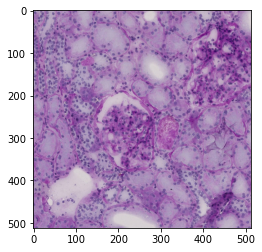

In [34]:
from matplotlib import pyplot as plt

plt.imshow(image[0])

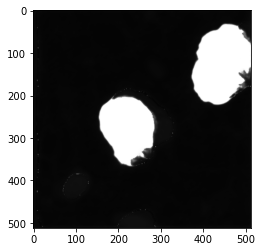

In [35]:
from matplotlib import pyplot as plt

plt.imshow(predicted[0,:,:,0], cmap="gray")

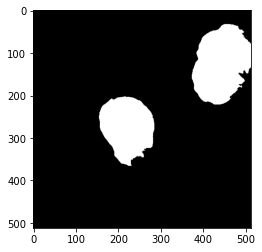

In [36]:
from matplotlib import pyplot as plt

plt.imshow(np.round(predicted[0,:,:,0]), cmap="gray")

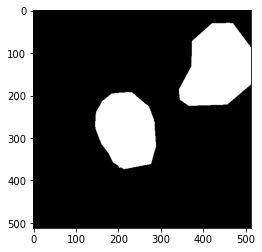

In [37]:
from matplotlib import pyplot as plt

plt.imshow(mask[0,:,:,0], cmap="gray")

In [15]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from time import time

import tensorflow_addons as tfa

start = time()

batch_size = 1

test_predict_info = []
mode = "train"
data_set_name = "glomerulus_0.65_512_not_filped_remove_peel"

result_path = f"images/{data_set_name}/check_state/{mode}"
os.makedirs(f"{result_path}/f1_score", exist_ok=True)
os.makedirs(f"{result_path}/order", exist_ok=True)
remove_folder_png_files(f"{result_path}/f1_score")
remove_folder_png_files(f"{result_path}/order")

dataset_path = os.path.join("datasets",data_set_name,mode)

img_path_list = glob(os.path.join(dataset_path, "image", '*.png'))
mask_path_list = glob(os.path.join(dataset_path, "mask", '*.png'))
train_data_length = len(img_path_list)

batch_num = train_data_length // batch_size
progressbar = display(progress(0, batch_num), display_id=True)

assert train_data_length % batch_size == 0

for batch_index in range(batch_num):

    img_array_list = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                      for img_path in img_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_array_list = [cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                      for img_array in img_array_list]
    img_array_list = np.array(img_array_list)
    img_array_list = (img_array_list / 127.5) - 1
    img_mask_list = [cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                     for mask_path in mask_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_mask_list = np.array(img_mask_list)
    img_mask_list = np.round((img_mask_list / 255)).astype('float32')

    converted_img_list = generator.predict(img_array_list)
    converted_img_list = np.round(converted_img_list).astype('float32')
    predicted_img_list = converted_img_list[:, :, :, 0]

    # get predict_info
    predict_info = []
    for y_true, y_pred in zip(img_mask_list, predicted_img_list):
        predict_info.append({
            'f1_score': dice_score(np.expand_dims(y_true, axis=[0,-1]), np.expand_dims(y_pred, axis=[0,-1])),
            'loss': weighted_region_loss(np.expand_dims(y_true, axis=[0,-1]), np.expand_dims(y_pred, axis=[0,-1])),
            'mask_ratio': np.mean(y_true),
        })
    test_predict_info += predict_info

    # Rescale images 0 - 1
    img_array_list = 0.5 * img_array_list + 0.5

    row_num = 3
    column_num = 1

    for index, (img_array, predict_array, mask_array) in enumerate(zip(img_array_list, predicted_img_list, img_mask_list)):

        current_index = batch_index * batch_size + index
        current_f1_score = np.round_(
            test_predict_info[current_index]['f1_score'], 3)
        current_loss = np.round_(
            test_predict_info[current_index]['loss'], 3)
        predict_array = cv2.cvtColor(predict_array, cv2.COLOR_GRAY2RGB)
        mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)

        gen_img = np.stack(
            [img_array, predict_array, mask_array], axis=0)
        if DRAW_IMAGES:

            titles = ["Original", "Model", "Man"]
            fig, axs = plt.subplots(row_num, column_num)
            for row_index in range(row_num):
                axs[row_index].imshow(gen_img[row_index])
                axs[row_index].set_title(titles[row_index])
                axs[row_index].axis("off")
            fig.set_size_inches(12, 12)
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/f1_score/{current_f1_score:.3f}_{current_loss:.3f}_{current_index}.png")
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/order/{current_index:0>4}_{current_f1_score:.3f}.png")
            plt.close()

    progressbar.update(progress(batch_index + 1, batch_num))

test_f1_scores = [predict_info['f1_score']
                  for predict_info in test_predict_info]

print(f'Max : {np.max(test_f1_scores)}')
print(f'Min :{np.min(test_f1_scores)}')
print(f'Mean :{np.mean(test_f1_scores)}')
print(f'Median :{np.median(test_f1_scores)}')
print(f'Elasped Time : {time()-start}')


Max : 1.0
Min :0.0
Mean :0.9392329454421997
Median :1.0
Elasped Time : 2927.0947053432465


In [18]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from time import time

import tensorflow_addons as tfa

start = time()

batch_size = 1

test_predict_info = []
mode = "valid"
data_set_name = "glomerulus_0.65_512_not_filped_remove_peel"

result_path = f"images/{data_set_name}/check_state/{mode}"
os.makedirs(f"{result_path}/f1_score", exist_ok=True)
os.makedirs(f"{result_path}/order", exist_ok=True)
remove_folder_png_files(f"{result_path}/f1_score")
remove_folder_png_files(f"{result_path}/order")

dataset_path = os.path.join("datasets",data_set_name,mode)

img_path_list = glob(os.path.join(dataset_path, "image", '*.png'))
mask_path_list = glob(os.path.join(dataset_path, "mask", '*.png'))
train_data_length = len(img_path_list)

batch_num = train_data_length // batch_size
progressbar = display(progress(0, batch_num), display_id=True)

assert train_data_length % batch_size == 0

for batch_index in range(batch_num):

    img_array_list = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                      for img_path in img_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_array_list = [cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                      for img_array in img_array_list]
    img_array_list = np.array(img_array_list)
    img_array_list = (img_array_list / 127.5) - 1
    img_mask_list = [cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                     for mask_path in mask_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_mask_list = np.array(img_mask_list)
    img_mask_list = np.round((img_mask_list / 255)).astype('float32')

    converted_img_list = generator.predict(img_array_list)
    converted_img_list = np.round(converted_img_list).astype('float32')
    predicted_img_list = converted_img_list[:, :, :, 0]

    # get predict_info
    predict_info = []
    for y_true, y_pred in zip(img_mask_list, predicted_img_list):
        predict_info.append({
            'f1_score': dice_score(np.expand_dims(y_true, axis=[0,-1]), np.expand_dims(y_pred, axis=[0,-1])),
            'loss': weighted_region_loss(np.expand_dims(y_true, axis=[0,-1]), np.expand_dims(y_pred, axis=[0,-1])),
            'mask_ratio': np.mean(y_true),
        })
    test_predict_info += predict_info

    # Rescale images 0 - 1
    img_array_list = 0.5 * img_array_list + 0.5

    row_num = 3
    column_num = 1

    for index, (img_array, predict_array, mask_array) in enumerate(zip(img_array_list, predicted_img_list, img_mask_list)):

        current_index = batch_index * batch_size + index
        current_f1_score = np.round_(
            test_predict_info[current_index]['f1_score'], 3)
        current_loss = np.round_(
            test_predict_info[current_index]['loss'], 3)
        predict_array = cv2.cvtColor(predict_array, cv2.COLOR_GRAY2RGB)
        mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)

        gen_img = np.stack(
            [img_array, predict_array, mask_array], axis=0)
        if DRAW_IMAGES:

            titles = ["Original", "Model", "Man"]
            fig, axs = plt.subplots(row_num, column_num)
            for row_index in range(row_num):
                axs[row_index].imshow(gen_img[row_index])
                axs[row_index].set_title(titles[row_index])
                axs[row_index].axis("off")
            fig.set_size_inches(12, 12)
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/f1_score/{current_f1_score:.3f}_{current_loss:.3f}_{current_index}.png")
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/order/{current_index:0>4}_{current_f1_score:.3f}.png")
            plt.close()

    progressbar.update(progress(batch_index + 1, batch_num))

test_f1_scores = [predict_info['f1_score']
                  for predict_info in test_predict_info]

print(f'Max : {np.max(test_f1_scores)}')
print(f'Min :{np.min(test_f1_scores)}')
print(f'Mean :{np.mean(test_f1_scores)}')
print(f'Median :{np.median(test_f1_scores)}')
print(f'Elasped Time : {time()-start}')


Max : 1.0
Min :0.0
Mean :0.9262773990631104
Median :1.0
Elasped Time : 347.9119131565094


In [19]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from time import time

import tensorflow_addons as tfa

start = time()

batch_size = 1

test_predict_info = []
mode = "test"
data_set_name = "glomerulus_0.65_512_not_filped_remove_peel"

result_path = f"images/{data_set_name}/check_state/{mode}"
os.makedirs(f"{result_path}/f1_score", exist_ok=True)
os.makedirs(f"{result_path}/order", exist_ok=True)
remove_folder_png_files(f"{result_path}/f1_score")
remove_folder_png_files(f"{result_path}/order")

dataset_path = os.path.join("datasets",data_set_name,mode)

img_path_list = glob(os.path.join(dataset_path, "image", '*.png'))
mask_path_list = glob(os.path.join(dataset_path, "mask", '*.png'))
train_data_length = len(img_path_list)

batch_num = train_data_length // batch_size
progressbar = display(progress(0, batch_num), display_id=True)

assert train_data_length % batch_size == 0

for batch_index in range(batch_num):

    img_array_list = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                      for img_path in img_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_array_list = [cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                      for img_array in img_array_list]
    img_array_list = np.array(img_array_list)
    img_array_list = (img_array_list / 127.5) - 1
    img_mask_list = [cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                     for mask_path in mask_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_mask_list = np.array(img_mask_list)
    img_mask_list = np.round((img_mask_list / 255)).astype('float32')

    converted_img_list = generator.predict(img_array_list)
    converted_img_list = np.round(converted_img_list).astype('float32')
    predicted_img_list = converted_img_list[:, :, :, 0]

    # get predict_info
    predict_info = []
    for y_true, y_pred in zip(img_mask_list, predicted_img_list):
        predict_info.append({
            'f1_score': dice_score(np.expand_dims(y_true, axis=[0,-1]), np.expand_dims(y_pred, axis=[0,-1])),
            'loss': weighted_region_loss(np.expand_dims(y_true, axis=[0,-1]), np.expand_dims(y_pred, axis=[0,-1])),
            'mask_ratio': np.mean(y_true),
        })
    test_predict_info += predict_info

    # Rescale images 0 - 1
    img_array_list = 0.5 * img_array_list + 0.5

    row_num = 3
    column_num = 1

    for index, (img_array, predict_array, mask_array) in enumerate(zip(img_array_list, predicted_img_list, img_mask_list)):

        current_index = batch_index * batch_size + index
        current_f1_score = np.round_(
            test_predict_info[current_index]['f1_score'], 3)
        current_loss = np.round_(
            test_predict_info[current_index]['loss'], 3)
        predict_array = cv2.cvtColor(predict_array, cv2.COLOR_GRAY2RGB)
        mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)

        gen_img = np.stack(
            [img_array, predict_array, mask_array], axis=0)
        if DRAW_IMAGES:

            titles = ["Original", "Model", "Man"]
            fig, axs = plt.subplots(row_num, column_num)
            for row_index in range(row_num):
                axs[row_index].imshow(gen_img[row_index])
                axs[row_index].set_title(titles[row_index])
                axs[row_index].axis("off")
            fig.set_size_inches(12, 12)
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/f1_score/{current_f1_score:.3f}_{current_loss:.3f}_{current_index}.png")
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/order/{current_index:0>4}_{current_f1_score:.3f}.png")
            plt.close()

    progressbar.update(progress(batch_index + 1, batch_num))

test_f1_scores = [predict_info['f1_score']
                  for predict_info in test_predict_info]

print(f'Max : {np.max(test_f1_scores)}')
print(f'Min :{np.min(test_f1_scores)}')
print(f'Mean :{np.mean(test_f1_scores)}')
print(f'Median :{np.median(test_f1_scores)}')
print(f'Elasped Time : {time()-start}')


Max : 1.0
Min :0.0
Mean :0.9320558905601501
Median :1.0
Elasped Time : 369.4145369529724


In [7]:
index = 0

img_array = img_array_list[index]
converted_array = converted_img_list[index:index+1]
predicted_array = converted_array[0,:,:,0]
predicted_array = np.round(predicted_array)
mask_array = img_mask_list[index]

In [ ]:
123.68, 116.779, 103.939 58.393, 57.12, 57.375

In [10]:
temp = img_array - [123.68, 116.779, 103.939]
print(np.min(temp))
print(np.max(temp))
temp = temp / [58.393, 57.12, 57.375]
print(np.min(temp))
print(np.max(temp))

-123.68
-102.939
-2.118062096484168
-1.7941437908496731


In [11]:
y_true = np.expand_dims(mask_array, axis=0)
y_pred = np.expand_dims(predicted_array, axis=0)

tp = tf.math.reduce_sum(y_true * y_pred, axis=[1,2])
tn = tf.math.reduce_sum((1-y_true) * (1-y_pred), axis=[1,2])
fp = tf.math.reduce_sum((1-y_true)*y_pred, axis=[1,2])
fn = tf.math.reduce_sum(y_true*(1-y_pred), axis=[1,2])

p = tp / (tp + fp + K.epsilon()) # Precision = tp / tp + fp
r = tp / (tp + fn + K.epsilon()) # Recall = tp / (tp+fn)

f1 = (2*p*r) / (p+r+K.epsilon())

print(K.mean(f1))

tf.Tensor(0.60074574, shape=(), dtype=float32)


In [12]:
y_true = np.expand_dims(mask_array, axis=[0,-1])
y_pred = np.expand_dims(predicted_array, axis=[0,-1])

tp = tf.math.reduce_sum(y_true * y_pred, axis=[1,2,3])
tn = tf.math.reduce_sum((1-y_true) * (1-y_pred), axis=[1,2,3])
fp = tf.math.reduce_sum((1-y_true)*y_pred, axis=[1,2,3])
fn = tf.math.reduce_sum(y_true*(1-y_pred), axis=[1,2,3])

p = tp / (tp + fp + K.epsilon()) # Precision = tp / tp + fp
r = tp / (tp + fn + K.epsilon()) # Recall = tp / (tp+fn)

f1 = (2*p*r) / (p+r+K.epsilon())

print(K.mean(f1))

tf.Tensor(0.60074574, shape=(), dtype=float32)


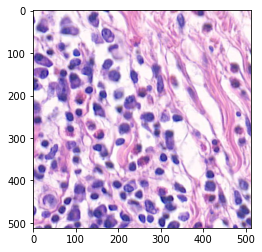

In [13]:
from matplotlib import pyplot as plt

plt.imshow(img_array)
plt.show()

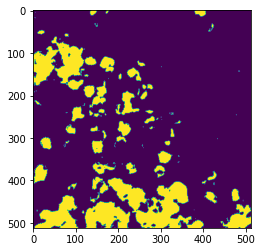

In [14]:
from matplotlib import pyplot as plt

plt.imshow(predicted_array)
plt.show()

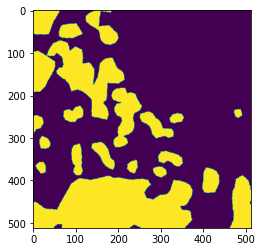

In [15]:
from matplotlib import pyplot as plt

plt.imshow(mask_array)
plt.show()

In [21]:
print(np.min(converted_array))
print(np.max(converted_array))

0.0
1.0


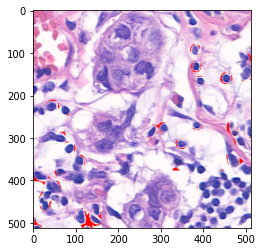

In [151]:
red_mask_img = img_array.copy()
true_negative_array = (1-mask_array) * predicted_array
true_negative_position = np.where(true_negative_array == 1) 
for i,j in zip(*true_negative_position):
    red_mask_img[i,j,0] = 1
    red_mask_img[i,j,1:] = 0

plt.imshow(red_mask_img)
plt.show()

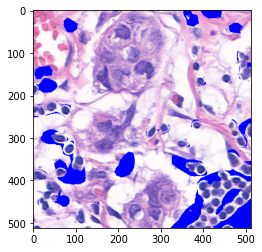

In [152]:
blue_mask_img = img_array.copy()
fail_to_predict_array = mask_array * (1-predicted_array)
fail_to_predict_position = np.where(fail_to_predict_array == 1) 
for i,j in zip(*fail_to_predict_position):
    blue_mask_img[i,j,0:2] = 0
    blue_mask_img[i,j,2] = 1

plt.imshow(blue_mask_img)
plt.show()

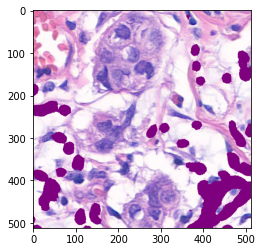

In [153]:
purple_mask_img = img_array.copy()
success_to_predict_array = mask_array * predicted_array
success_to_predict_position = np.where(success_to_predict_array == 1)
for i,j in zip(*success_to_predict_position):
    purple_mask_img[i,j,0] = 0.5
    purple_mask_img[i,j,1] = 0
    purple_mask_img[i,j,2] = 0.5
plt.imshow(purple_mask_img)
plt.show()

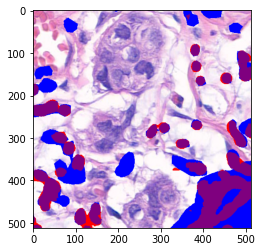

In [155]:
masked_img = img_array.copy()

true_negative_array = (1-mask_array) * predicted_array
true_negative_position = np.where(true_negative_array == 1) 
for i,j in zip(*true_negative_position):
    masked_img[i,j,0] = 1
    masked_img[i,j,1:] = 0
    
fail_to_predict_array = mask_array * (1-predicted_array)
fail_to_predict_position = np.where(fail_to_predict_array == 1) 
for i,j in zip(*fail_to_predict_position):
    masked_img[i,j,0:2] = 0
    masked_img[i,j,2] = 1
    
success_to_predict_array = mask_array * predicted_array
success_to_predict_position = np.where(success_to_predict_array == 1)
for i,j in zip(*success_to_predict_position):
    masked_img[i,j,0] = 0.5
    masked_img[i,j,1] = 0
    masked_img[i,j,2] = 0.5
    
plt.imshow(masked_img)
plt.show()

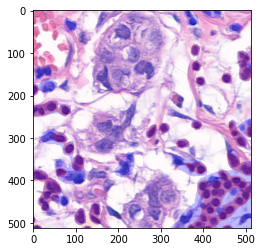

In [154]:
overlayed_img = cv2.addWeighted(red_mask_img, 0.5, img_array, 0.5,0)
overlayed_img = cv2.addWeighted(blue_mask_img, 0.5, overlayed_img, 0.5,0)
overlayed_img = cv2.addWeighted(purple_mask_img, 0.5, overlayed_img, 0.5,0)
plt.imshow(overlayed_img)
plt.show()

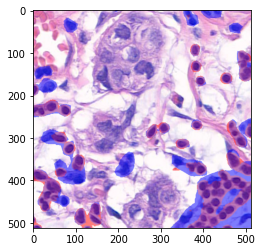

In [158]:
overlayed_img = cv2.addWeighted(masked_img, 0.5, img_array, 0.5,0)
plt.imshow(overlayed_img)
plt.show()

In [ ]:
123.68, 116.779, 103.939 58.393, 57.12, 57.375

In [12]:
import cv2

def imread(path, channel=None):
    image_byte_stream = open(path.encode("utf-8"), "rb")
    image_byte_array = bytearray(image_byte_stream.read())
    image_numpy_array = np.asarray(image_byte_array, dtype=np.uint8)
    image_numpy_array = cv2.imdecode(
        image_numpy_array, cv2.IMREAD_UNCHANGED)

    if channel == 'bgr':
        image_numpy_array = cv2.cvtColor(
            image_numpy_array, cv2.COLOR_BGR2RGB)

    return image_numpy_array

In [47]:
img_array = imread("./datasets/tumor/valid/image/0.png", channel="bgr")

In [40]:
img_array_rgb_sumed[0,0]

630

In [45]:
np.max(img_array)

0

In [49]:
from copy import deepcopy
img_array_rgb_sumed = np.sum(img_array,axis=-1)
temp = deepcopy(img_array)
temp[:,:,0] = temp[:,:,0] / img_array_rgb_sumed

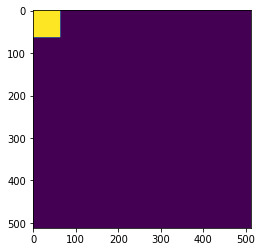

In [1]:
import numpy as np
from matplotlib import pyplot as plt

temp = np.zeros((512,512))
temp[:64, :64] = 1

plt.imshow(temp)

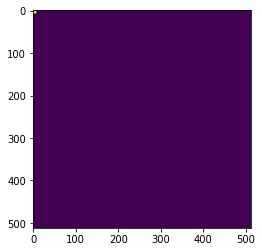

In [2]:
temp = np.zeros((512,512))
temp[:8, :8] = 1

plt.imshow(temp)

In [3]:
8*64

512

In [11]:
import numpy as np
import cv2

def imread(path, channel=None):
    image_byte_stream = open(path.encode("utf-8"), "rb")
    image_byte_array = bytearray(image_byte_stream.read())
    image_numpy_array = np.asarray(image_byte_array, dtype=np.uint8)
    image_numpy_array = cv2.imdecode(
        image_numpy_array, cv2.IMREAD_UNCHANGED)
    if channel == "rgb":
        image_numpy_array = cv2.cvtColor(
            image_numpy_array, cv2.COLOR_BGR2RGB)
    if len(image_numpy_array.shape) == 2:
        image_numpy_array = np.expand_dims(image_numpy_array, axis=-1)
    return image_numpy_array

In [12]:
temp = imread("./datasets/glomerulus_0.65_1024/test/image/0.png")

In [14]:
temp.shape

(1024, 1024, 3)

In [15]:
temp = imread("./datasets/glomerulus_0.65_1024/test/mask/0.png")

In [16]:
temp.shape

(1024, 1024, 1)

In [109]:
import numpy as np

temp = np.array([1,1,1])

In [110]:
temp

array([1, 1, 1])

In [111]:
np.quantile(temp, 0.1)

1.0

In [ ]:
AXIS = [1, 2, 3]
LOSS_WEIGHT_COEF = 2
PIE_VALUE = np.pi

def region_loss(y_true, y_pred):

    true_ratio = tf.math.reduce_mean(y_true, axis=AXIS)

    positive_f1 = sm.losses.DiceLoss(per_image=True)(
        y_true, y_pred) * (1 - true_ratio)
    negative_f1 = sm.losses.DiceLoss(per_image=True)(
        1 - y_true, 1 - y_pred) * true_ratio

    return positive_f1 + negative_f1

def weighted_region_loss(y_true, y_pred):

    y_true = 1 - tf.math.cos(y_true * PIE_VALUE / 2)
    y_pred = 1 - tf.math.cos(y_pred * PIE_VALUE / 2)

    return region_loss(y_true, y_pred)

def f1_loss(y_true, y_pred):

    true_region = tf.math.reduce_mean(y_true, axis=AXIS)
    true_region = K.maximum(true_region, 0.01)
    
    tp = tf.math.reduce_sum(y_true * y_pred, axis=AXIS)
    tn = tf.math.reduce_sum((1 - y_true) * (1 - y_pred), axis=AXIS)
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=AXIS)
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=AXIS)

    f1_postive = 2 * tp / (2 * tp + fn + fp + K.epsilon())
    f1_negative = 2 * tn / (2 * tn + fp + fn + K.epsilon())
    
    valid_f1_loss = K.maximum(f1_postive, f1_negative)
    print(f1_postive)
    print(f1_negative)
    return K.mean(valid_f1_loss)